# Optimization Reports

### Imports

In [1]:
import json
import time
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
warnings.filterwarnings('ignore')

### Setup

In [2]:
# SpaCy model
nlp = spacy.load('en_core_web_sm')

In [3]:
# Load dataset
def load_dataset(path='../dataset/philippine-legal-dataset.json'):
    with open(path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    return dataset

### Import Models

In [4]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [5]:
# Models
from models.tfidf_cosine import TFIDFCosineSimilarity
from models.okapi_bm25 import BM25Similarity
from models.jaccard import JaccardSimilarity
from models.sbert import SentenceBERTSimilarity
from models.bertscore import BERTScoreSimilarity

### Run Evaluations

In [6]:
dataset = load_dataset()

In [58]:
from evaluation.metrics import evaluate_model

traditional_ablation_results = {
    "TF-IDF Raw": evaluate_model(TFIDFCosineSimilarity(use_preprocessing=False), dataset),
    "TF-IDF Preprocessed": evaluate_model(TFIDFCosineSimilarity(), dataset),
    "BM25 Raw": evaluate_model(BM25Similarity(use_preprocessing=False), dataset),
    "BM25 Preprocessed": evaluate_model(BM25Similarity(), dataset),
    "Jaccard Raw": evaluate_model(JaccardSimilarity(use_preprocessing=False), dataset),
    "Jaccard Preprocessed": evaluate_model(JaccardSimilarity(), dataset)
}

embedding_based_results = {
    "SBERT (all-Mini-LM-l6-v2)": evaluate_model(SentenceBERTSimilarity(model_name='all-MiniLM-L6-v2'), dataset),
    "SBERT (all-mpnet-base-v2)": evaluate_model(SentenceBERTSimilarity(model_name='all-mpnet-base-v2'), dataset),
    "SBERT (multi-qa-mpnet-base-dot-v1)": evaluate_model(SentenceBERTSimilarity(model_name='multi-qa-mpnet-base-dot-v1'), dataset)
}

In [22]:
advanced_metrics_results = {
    "BERTScore (distilbert-base-uncased)": evaluate_model(BERTScoreSimilarity(model_type='distilbert-base-uncased'), dataset),
    "BERTScore (microsoft/deberta-base-mnli)": evaluate_model(BERTScoreSimilarity(model_type='microsoft/deberta-base-mnli'), dataset),
    "BERTScore (deberta-xlarge-mnli)": evaluate_model(BERTScoreSimilarity(), dataset)
}

In [59]:
import pandas as pd
# Convert traditional ablation results to DataFrame
lexical_df = pd.DataFrame.from_dict(traditional_ablation_results, orient='index')
lexical_df.index.name = "Model Variant"
lexical_df.reset_index(inplace=True)
lexical_df = lexical_df.round(4)

# Convert embedding-based (SBERT) results to DataFrame
embedding_df = pd.DataFrame.from_dict(embedding_based_results, orient='index')
embedding_df.index.name = "Model Variant"
embedding_df.reset_index(inplace=True)
embedding_df = embedding_df.round(4)

# Convert advanced metrics (BERTScore) results to DataFrame
bertscore_df = pd.DataFrame.from_dict(advanced_metrics_results, orient='index')
bertscore_df.index.name = "Model Variant"
bertscore_df.reset_index(inplace=True)
bertscore_df = bertscore_df.round(4)

In [60]:
lexical_df

,Model Variant,Precision@1,Precision@3,Recall@3,MRR,Runtime (in seconds),Peak Memory (in KB)
0,TF-IDF Raw,0.88,0.6400,0.6400,0.9333,0.8614,283.8955
1,TF-IDF Preprocessed,0.98,0.6933,0.6933,0.9867,7.9451,1716.3027
2,BM25 Raw,0.74,0.5533,0.5533,0.8533,0.0670,17.1816
3,BM25 Preprocessed,0.94,0.6867,0.6867,0.9700,6.7471,1664.9365
4,Jaccard Raw,0.66,0.5533,0.5533,0.8100,0.0258,22.5283
5,Jaccard Preprocessed,0.96,0.6867,0.6867,0.9767,7.0871,1675.7422


In [50]:
embedding_df

,Model Variant,Precision@1,Precision@3,Recall@3,MRR,Runtime (in seconds),Peak Memory (in KB)
0,SBERT (all-Mini-LM-l6-v2),0.98,0.8200,0.8200,0.99,3.9992,86.3008
1,SBERT (all-mpnet-base-v2),1.00,0.8933,0.8933,1.00,23.3353,112.7715
2,SBERT (multi-qa-mpnet-base-dot-v1),1.00,0.8733,0.8733,1.00,25.8536,115.4600


In [26]:
bertscore_df

,Model Variant,Precision@1,Precision@3,Recall@3,MRR,Runtime (in seconds),Peak Memory (in KB)
0,BERTScore (distilbert-base-uncased),0.96,0.8333,0.8333,0.9800,206.1457,14140.0605
1,BERTScore (microsoft/deberta-base-mnli),0.90,0.7267,0.7267,0.9467,401.1784,51336.2510
2,BERTScore (deberta-xlarge-mnli),0.82,0.6733,0.6733,0.9067,875.7497,25855.4160


## Dimensionality Reduction Study

In [61]:
tfidf_dr = {
    "None": evaluate_model(TFIDFCosineSimilarity(), dataset),
    "50": evaluate_model(TFIDFCosineSimilarity(use_dimensionality_reduction=True, n_components=50), dataset),
    "100": evaluate_model(TFIDFCosineSimilarity(use_dimensionality_reduction=True, n_components=100), dataset),
    "200": evaluate_model(TFIDFCosineSimilarity(use_dimensionality_reduction=True, n_components=200), dataset),
    "300": evaluate_model(TFIDFCosineSimilarity(use_dimensionality_reduction=True, n_components=300), dataset)
}

In [62]:
tfidf_df = pd.DataFrame.from_dict(tfidf_dr, orient='index')
tfidf_df.index.name = "n_components"
tfidf_df.reset_index(inplace=True)
tfidf_df = tfidf_df.round(4)

In [63]:
tfidf_df

,n_components,Precision@1,Precision@3,Recall@3,MRR,Runtime (in seconds),Peak Memory (in KB)
0,None,0.98,0.6933,0.6933,0.9867,8.5523,1698.5156
1,50,0.98,0.7267,0.7267,0.9867,13.4299,1737.9834
2,100,0.98,0.7400,0.7400,0.9867,13.3360,1746.9883
3,200,0.98,0.7267,0.7267,0.9867,9.3072,1726.7861
4,300,0.98,0.7467,0.7467,0.9867,7.6799,1720.5576


## Visualizations

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(results_dict, metrics=None):
    if metrics is None:
        metrics = ["Precision@1", "Precision@3", "Recall@3", "MRR"]

    num_metrics = len(metrics)
    rows = (num_metrics + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        values = [results[metric] for results in results_dict.values()]
        keys = list(results_dict.keys())

        # Just use default colors, no palette passed
        sns.barplot(x=keys, y=values, ax=axes[i])
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=30)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [38]:
def plot_runtime_memory(results_dict):
    labels = list(results_dict.keys())
    runtime = [results["Runtime (in seconds)"] for results in results_dict.values()]
    memory = [results["Peak Memory (in KB)"] for results in results_dict.values()]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.barplot(x=labels, y=runtime, ax=axes[0])
    axes[0].set_title("Runtime (sec)")
    axes[0].set_xticklabels(labels, rotation=30)

    sns.barplot(x=labels, y=memory, ax=axes[1])
    axes[1].set_title("Peak Memory (KB)")
    axes[1].set_xticklabels(labels, rotation=30)
    
    plt.tight_layout()
    plt.show()


# Visualizations/Reports

## Traditional Methods (TFIDF Cosine, BM25, Jaccard)

### Preprocessing Ablation Study

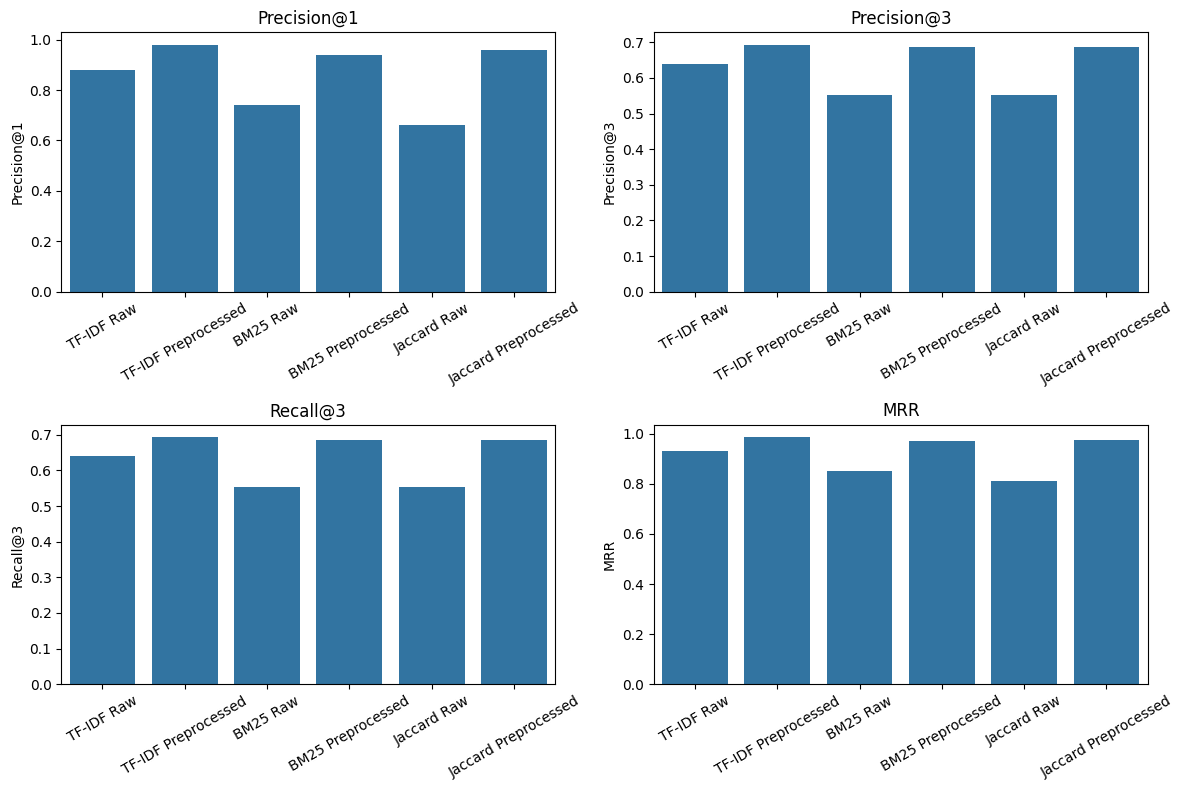

In [32]:
plot_metrics(traditional_ablation_results)

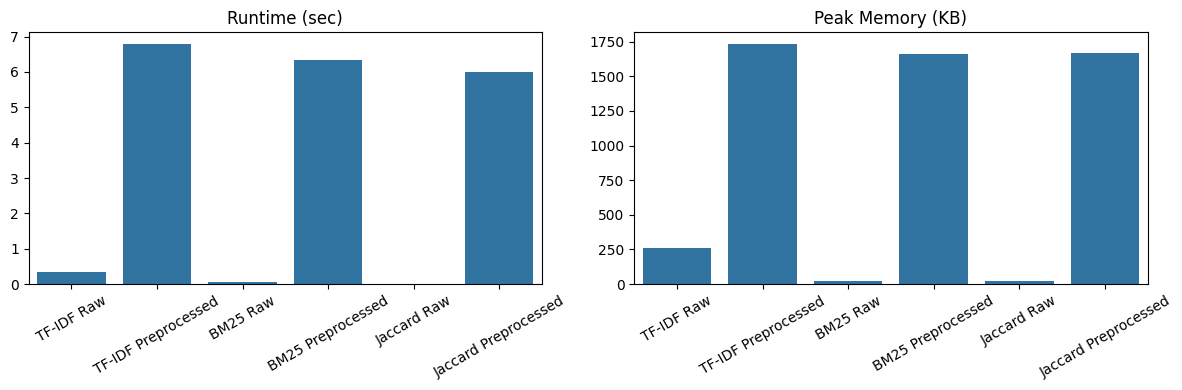

In [33]:
plot_runtime_memory(traditional_ablation_results)

### Speed-Accuracy Tradeoff curves

In [42]:
def plot_speed_accuracy_grid(results_dict, accuracy_metrics=None):
    if accuracy_metrics is None:
        accuracy_metrics = ["MRR", "Precision@1", "Precision@3", "Recall@3"]

    runtimes = [results["Runtime (in seconds)"] for results in results_dict.values()]
    labels = list(results_dict.keys())

    num_metrics = len(accuracy_metrics)
    rows = (num_metrics + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, metric in enumerate(accuracy_metrics):
        accuracies = [results[metric] for results in results_dict.values()]

        sns.scatterplot(x=runtimes, y=accuracies, ax=axes[i])

        for j, label in enumerate(labels):
            axes[i].text(runtimes[j] + 0.01, accuracies[j], label, fontsize=9)

        axes[i].set_title(f"Speed-Accuracy Tradeoff ({metric})")
        axes[i].set_xlabel("Runtime (sec)")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


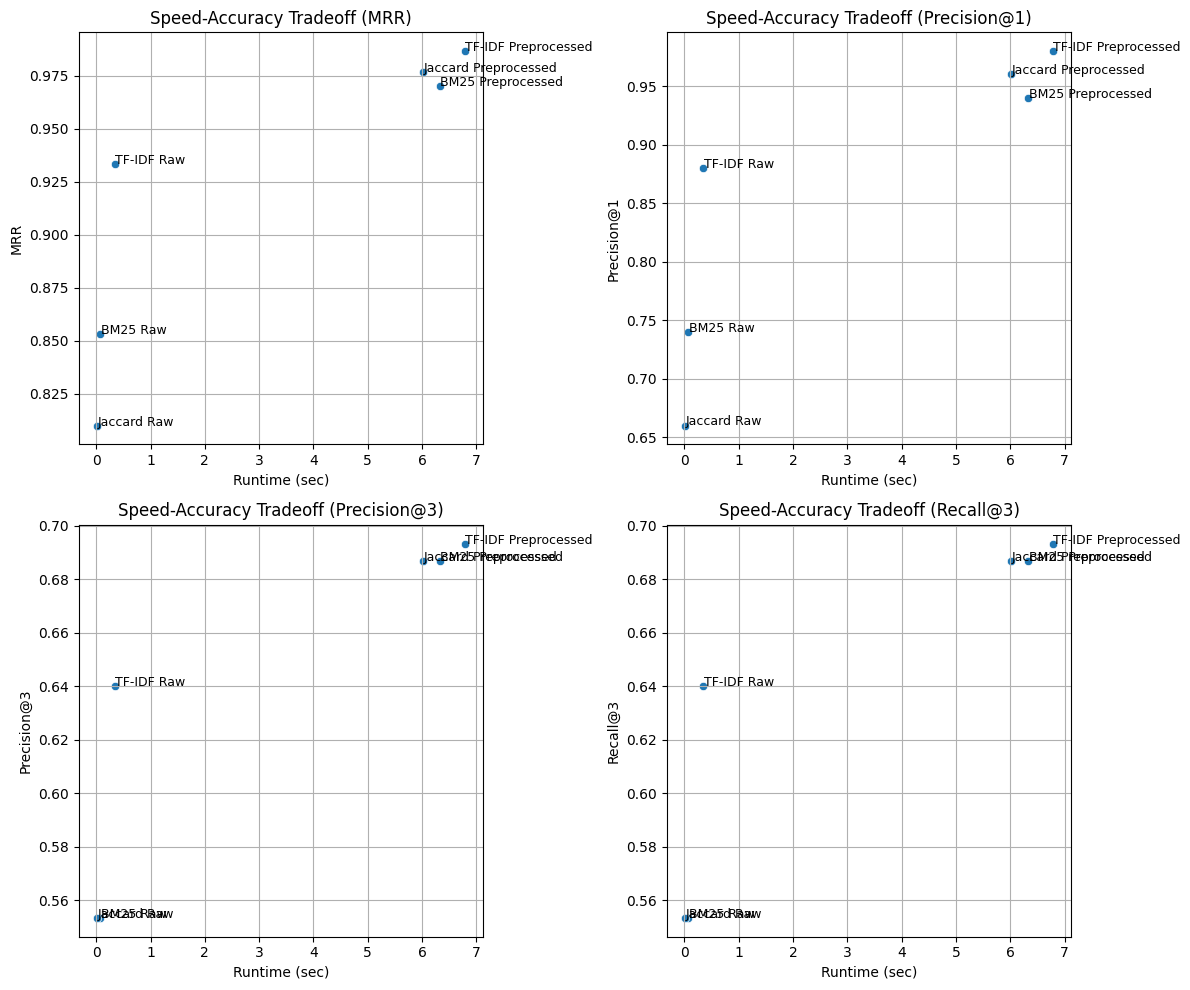

In [43]:
plot_speed_accuracy_grid(traditional_ablation_results)

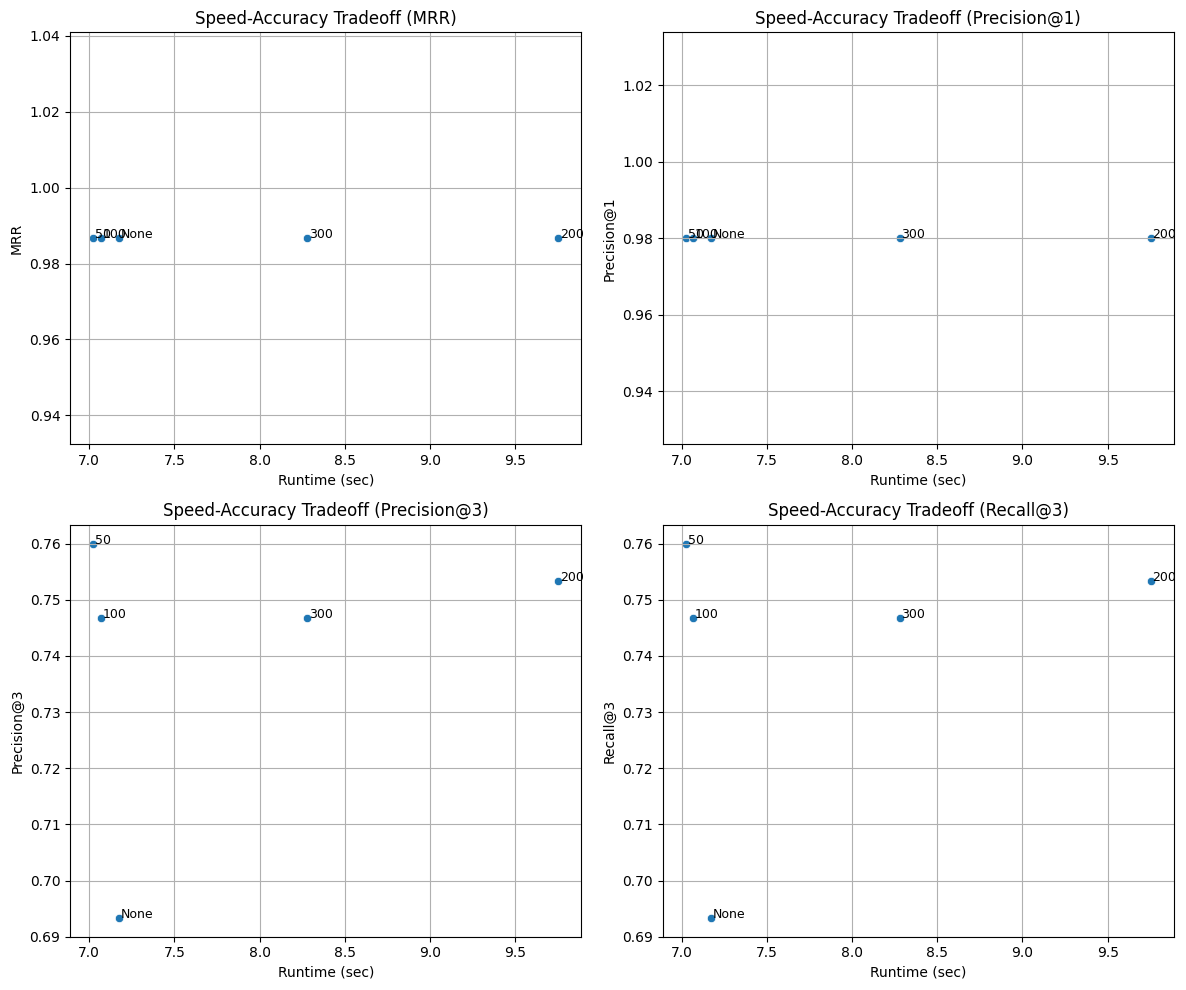

In [57]:
plot_speed_accuracy_grid(tfidf_dr)

## Sentence BERT

### Ablation Study

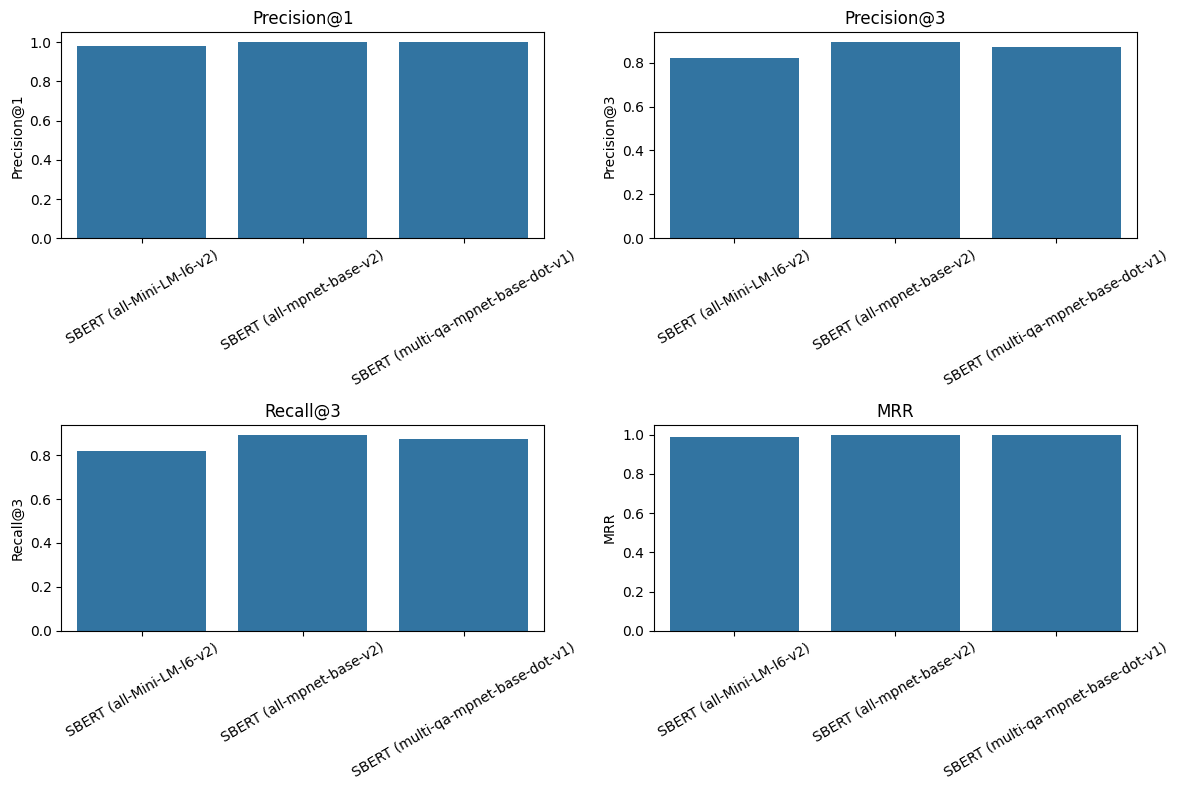

In [51]:
plot_metrics(embedding_based_results)

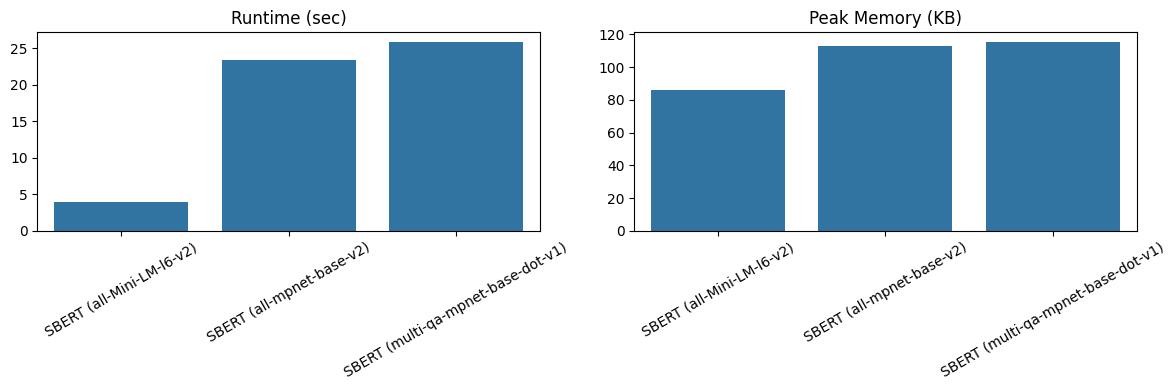

In [52]:
plot_runtime_memory(embedding_based_results)

### Speed-Accuracy Tradeoff

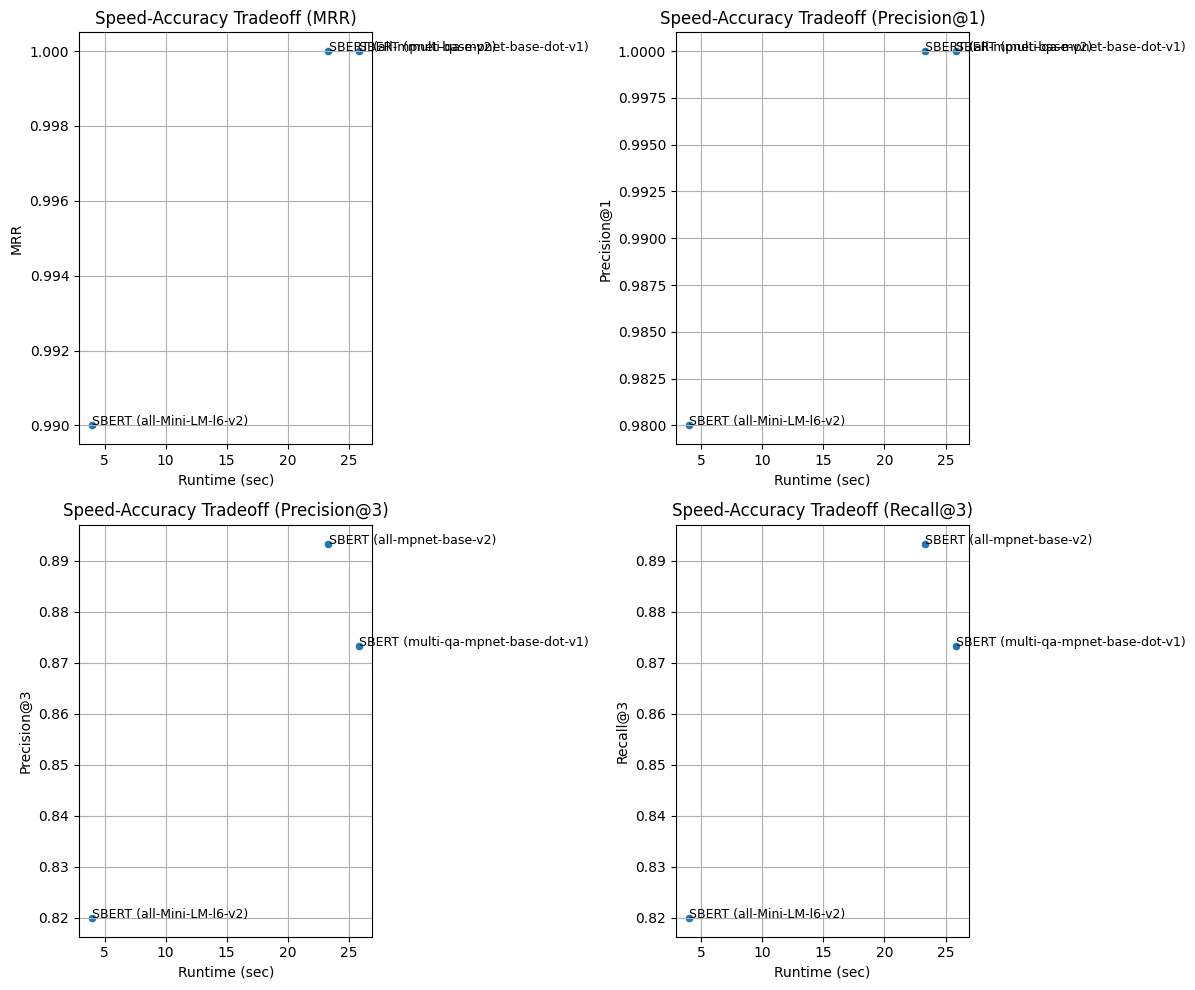

In [53]:
plot_speed_accuracy_grid(embedding_based_results)

## BERTScore

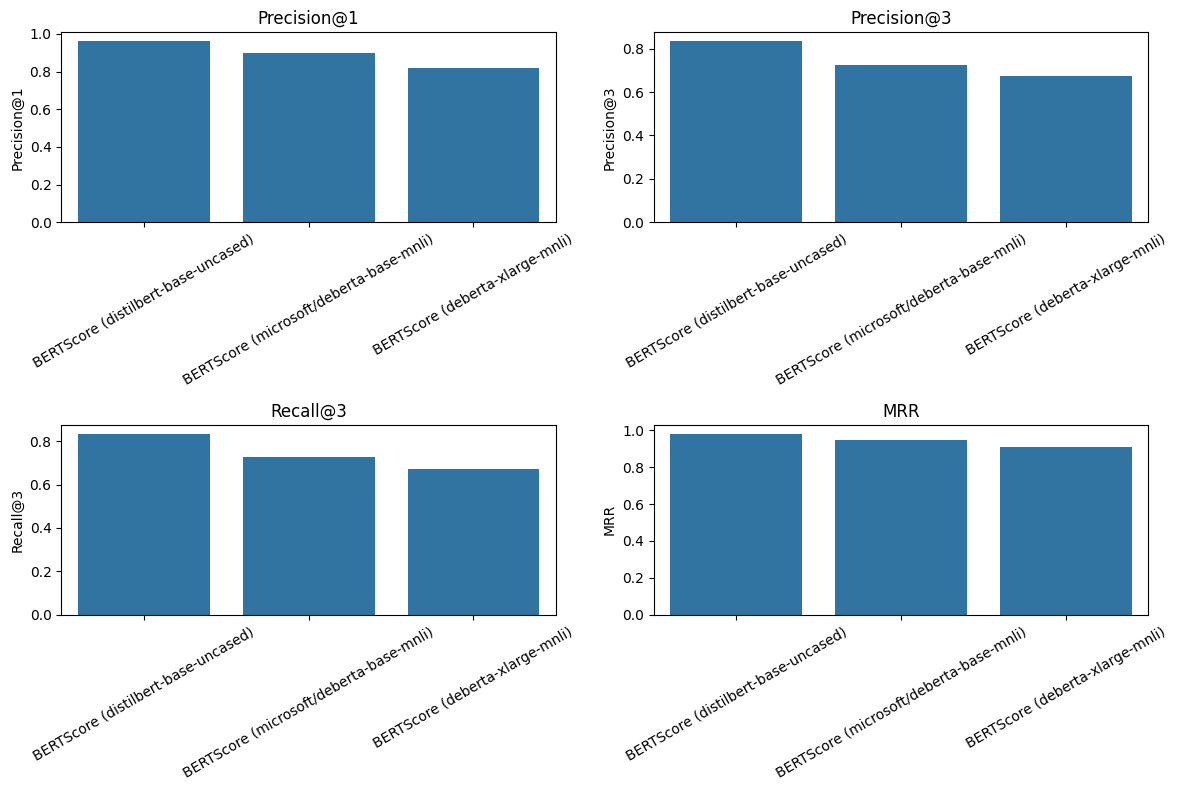

In [54]:
plot_metrics(advanced_metrics_results)

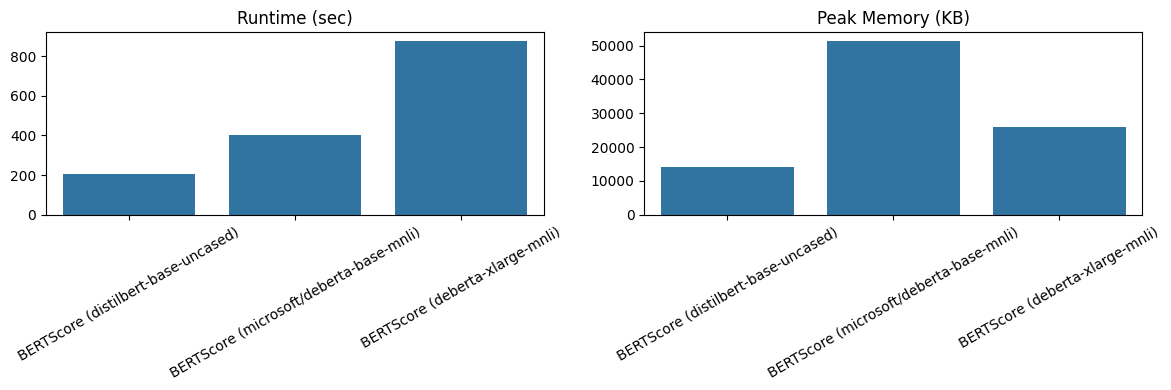

In [55]:
plot_runtime_memory(advanced_metrics_results)

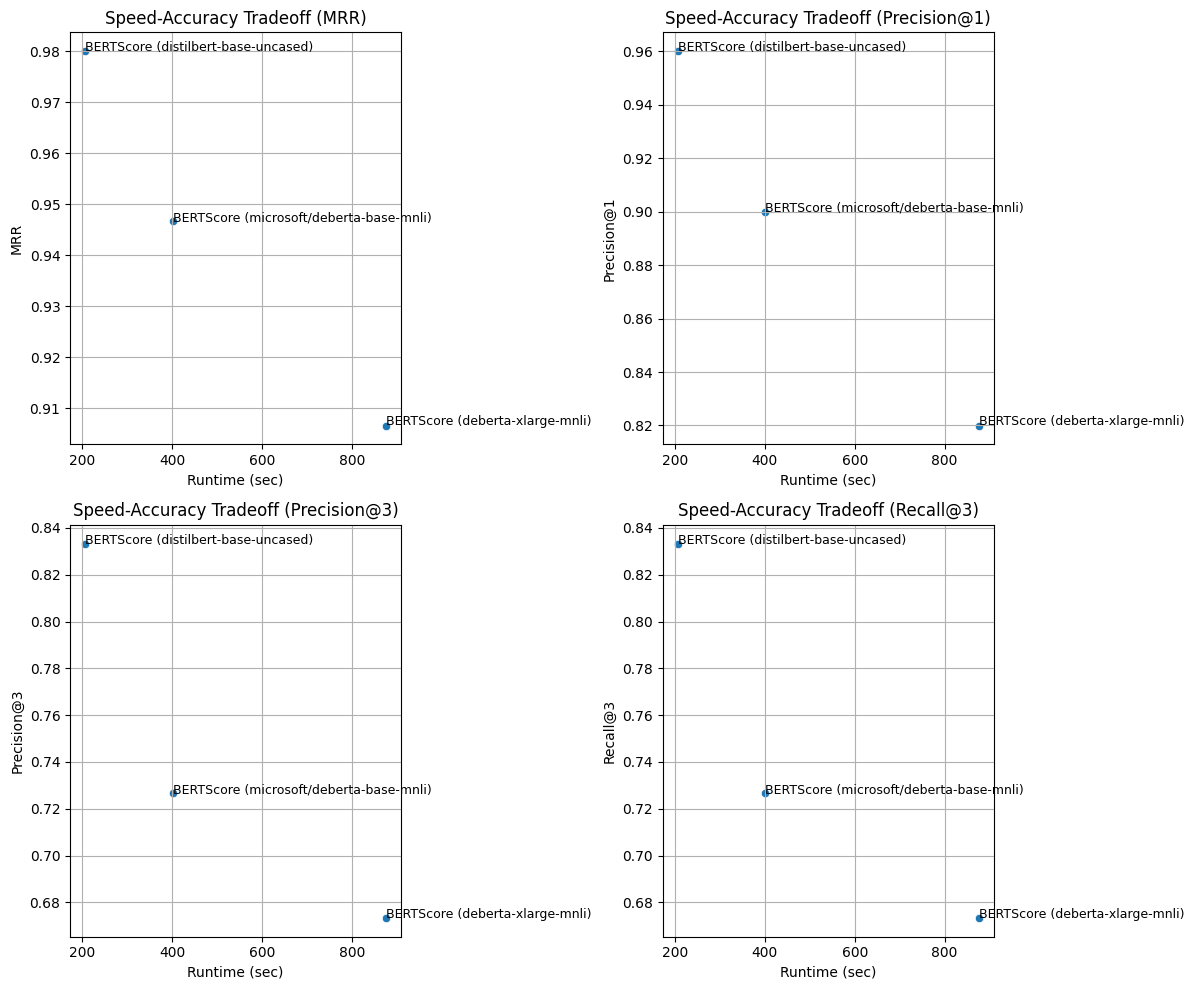

In [56]:
plot_speed_accuracy_grid(advanced_metrics_results)